Data: https://www.kaggle.com/datasets/rxsraghavagrawal/book-recommender-system

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

### Loading dataset

We have three set of csv files with semi-colon as separator. We would be importing all the three files.

In [2]:
books = pd.read_csv("BX-Books.csv", sep=';', encoding="latin-1", error_bad_lines=False)
users = pd.read_csv("BX-Users.csv", sep=';', encoding="latin-1", error_bad_lines=False)
ratings = pd.read_csv("BX-Book-Ratings.csv", sep=';', encoding="latin-1", error_bad_lines=False)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [3]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


In [4]:
books.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [5]:
users.head(2)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [6]:
ratings.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


### EDA and pre-processing

We start by dropping image URLs from dataframe books

In [7]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

In [8]:
#renaming some of the columns for convenience
books.rename(columns = {'Book-Title':'title', 'Book-Author':'author', 'Year-Of-Publication':'year'}, inplace=True)
users.rename(columns = {'User-ID':'userid'}, inplace=True)
ratings.rename(columns = {'User-ID':'userid', 'Book-Rating':'rating'}, inplace=True)

In [9]:
#keeping only users who have provided more that 100 ratings
uid = ratings['userid'].value_counts()>100
y = uid[uid].index  #user_ids
print(y.shape)

(1825,)


In [10]:
ratings = ratings[ratings['userid'].isin(y)]
print(ratings.shape)

(656605, 3)


### Merging ratings and books

In [11]:
df1 = ratings.merge(books, on='ISBN')
df1.head(2)

,userid,ISBN,rating,title,author,year,Publisher
0,276925,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
1,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc


In [12]:
#getting count of ratings and keep records with atleast 25 ratings
count_rating = df1.groupby('title')['rating'].count().reset_index()
count_rating.rename(columns= {'rating':'ratings_count'}, inplace=True)
data = df1.merge(count_rating, on='title')
data = data[data['ratings_count'] >= 25]
data.drop_duplicates(['userid','title'], inplace=True)
data.shape

(163583, 8)

In [13]:
data.head(2)

,userid,ISBN,rating,title,author,year,Publisher,ratings_count
0,276925,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,105
1,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,105


In [14]:
print(data.isnull().sum())

userid           0
ISBN             0
rating           0
title            0
author           0
year             0
Publisher        0
ratings_count    0
dtype: int64


In [15]:
data.describe()

,userid,rating,ratings_count
count,163583.000000,163583.000000,163583.000000
mean,139897.692633,2.112206,86.258444
std,80328.699263,3.608552,74.015321
min,183.000000,0.000000,25.000000
25%,69697.000000,0.000000,38.000000
50%,140000.000000,0.000000,60.000000
75%,211426.000000,5.000000,107.000000
max,278418.000000,10.000000,615.000000


**Top 10 books with high rating count**

<AxesSubplot:xlabel='ratings_count', ylabel='title'>

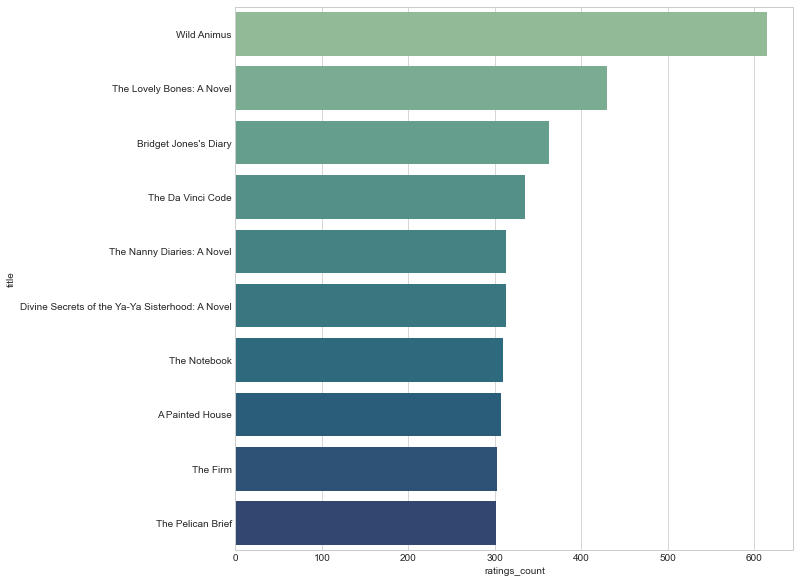

In [16]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 10))
df2 = data[['title','ratings_count']].drop_duplicates().sort_values(by='ratings_count', ascending=False).head(10)
sns.barplot(x="ratings_count", y="title", data=df2, palette='crest')

### Removing encoded characters

In [17]:
data[['title']] = data[['title']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

### Using lower case on titles

In [18]:
data['title'] = data['title'].str.lower()

#### Recommendation Systems

Recommedations can be based on three types

- **Content Based Filtering:** Under this type of recommendations, tags are used. For example if user 1 reads Book A, B with certain tags associated with them and there are other books C, D which have similar tags associated to them then user 1 will be recommended books C and D.


- **Collaborative Based Filtering:** This type of recommendation is based on users. If two users are watching similar contents then their respective choices will be recommended to each other as well. For example, if user 1 reads Books A, B and user 2 reads Books B, C then user 1 would be recommended Book C while user 2 will be recommended Book A.


- **Hybrid Filtering**: This is a mixture of both above methods.

For the scope of this project, we would be implementing **Collorative Based Filtering**. This used matrix factorization, for which we will be using pivot of our data as below.

### Pivoting table

In [19]:
data_pivot = data.pivot_table(columns='userid', index='title', values="rating")
data_pivot.fillna(0, inplace=True)
data_pivot

userid,183,254,507,882,1424,1435,1733,1903,2033,2110,...,276018,276463,276680,276925,277427,277478,277639,278137,278188,278418
title,,,,,,,,,,,,,,,,,,,,,
'salem's lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 lb. penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 dalmatians,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 lighthouse road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
your oasis on flame lake (ballantine reader's circle),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zen and the art of motorcycle maintenance: an inquiry into values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#As we have numerous zero values in our matrix which would affect computation, we compress the data to sparse matrix
data_sparse = csr_matrix(data_pivot)

### Modelling: Fitting the model to KNN

In [21]:
model = NearestNeighbors(algorithm='brute')
model.fit(data_sparse)

NearestNeighbors(algorithm='brute')

In [22]:
distances, recommendations = model.kneighbors(data_pivot.iloc[237, :].values.reshape(1, -1))

In [23]:
for i in range(len(recommendations)):
    print(data_pivot.index[recommendations[i]])

Index(['atonement : a novel', 'long, lean, and lethal', 'house', 'blind spot',
       'great expectations'],
      dtype='object', name='title')


In [24]:
book_name = input("Enter name of a book: ")

if book_name.lower() in data_pivot.index:
    distances, recommendations = model.kneighbors(data_pivot.loc[[book_name]].values.reshape(1, -1))
    recom_list = data_pivot.index[recommendations[0]]
    print("\nRecommended Books:")
    for i in range(1,len(recom_list)):
        print("\t",recom_list[i])
else:
    print("\nEntered book not found!! Please try with a different book.")

Enter name of a book: young wives

Recommended Books:
	 snow in august
	 commitments
	 people like us
	 house


Reference: https://www.analyticsvidhya.com/blog/2021/06/build-book-recommendation-system-unsupervised-learning-project/